# MLP language model using embeddings

Based on 1000 boy names, see how a language model manages to generate new random ones based on a MLP network using embeddings for each character. Code inspired by https://github.com/karpathy/nn-zero-to-hero/blob/master/lectures/makemore/makemore_part2_mlp.ipynb and network based on https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

In [1]:
import torch
import torch.nn.functional as F
import os
import random
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
with open("../data/names.txt", "r") as f:
    names = f.read().splitlines()
    print(f"{len(names)} names loaded. Examples: {names[:3]}..")

1000 names loaded. Examples: ['Aarav', 'Aaron', 'Abdiel']..


### Create vocab

- Store all unique characters in a vocab. 
    - Also add a unique token indicating that a word starts and ends.
- Keep capital letters (So we can see if model is smart enough to start names with capital later)
- Create dicts to help us map between chars and index in vocab

In [3]:
START_TOKEN, END_TOKEN = "(", ")"
vocab = [START_TOKEN] + sorted(list(set("".join(names)))) + [END_TOKEN]
print(f"Vocab of size {len(vocab)}")
# Create "string to index" and "index to string" dicts for lookup purposes
stoi = {s:i for i, s in enumerate(vocab)}
itos = {i:s for i, s in enumerate(vocab)}
print(f"Index of character 'x' = {stoi['x']}")
print(f"Character of index 26 = {itos[26]}")

Vocab of size 54
Index of character 'x' = 50
Character of index 26 = Z


### Dataset

Given a torch tensor containing `context_size` number of previous characters, the network should output the probabilities of each character in the vocab to come after the input.

In [4]:
def init_dataset(names, context_size=3):
    # context_size: Number of characters as context when predicting next word
    X, Y = [], [] # Given X, predict Y
    for name in names:
        # First character in a name have padded START_TOKEN as context
        context = [stoi[START_TOKEN]] * context_size 
        for char in name + END_TOKEN: # E.g. A, d, a, m, )
            idx = stoi[char] 
            X.append(context)
            Y.append(idx)
            # Context for next char in the name
            context = context[1:] + [idx]
    X, Y = torch.tensor(X), torch.tensor(Y)
    return X, Y

In [5]:
X, Y = init_dataset(names, context_size=3)
print(f"X: {X.shape}, Y: {Y.shape}")

X: torch.Size([6666, 3]), Y: torch.Size([6666])


In [6]:
for i in torch.randint(0, X.shape[0], (5,)): # 5 random samples in X
    print(f"Given {X[i]} predict {Y[i]}")
    print(f"{[itos[j] for j in X[i].tolist()]} -> {itos[Y[i].item()]}")

Given tensor([31, 35, 38]) predict 53
['e', 'i', 'l'] -> )
Given tensor([0, 0, 0]) predict 10
['(', '(', '('] -> J
Given tensor([ 0,  2, 51]) predict 44
['(', 'B', 'y'] -> r
Given tensor([0, 0, 0]) predict 26
['(', '(', '('] -> Z
Given tensor([27, 39, 27]) predict 44
['a', 'm', 'a'] -> r


## Network

Based on https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf


<img src="../assets/network.png"  alt="Neural Network Architecture" height="300">

In [7]:
vocab_size = len(vocab)
embedding_dim = 10
context_size = 3
layer1_size = 100

C = torch.randn((vocab_size, embedding_dim)) # Embeddings
W1 = torch.randn((context_size * embedding_dim, layer1_size))
b1 = torch.randn(layer1_size)
W2 = torch.randn((W1.shape[1], vocab_size))
b2 = torch.randn(vocab_size)
parameters = [C, W1, b1, W2, b2]

In [8]:
print((
    f"Embedding table {C.shape} meaning each of the {C.shape[0]} tokens in the vocab "
    f"have embedding vector of shape {C.shape[1]}\n"
    f"Example: embeddings of vocab item i=6 ({itos[6]}) = {C[6]}\n"
))
print(
    f"Weights in layer 1 with shape {W1.shape} + bias of shape {b1.shape} "
    f"meaning {W1.shape[0]} numbers go into this layer and {W1.shape[1]} goes out. "
    f"The {W1.shape[0]} inputs from embeddings table is because the network is configured to "
    f"take {context_size} char as context and each char have {embedding_dim} embeddings, I.e. "
    f"{context_size}*{embedding_dim}={W1.shape[0]}\n"
)

print(
    f"Weights in output layer is of shape {W2.shape} + bias of shape {b2.shape} "
    f"meaning the {W2.shape[0]} outputs from layer 1 goes in and it outputs "
    f"{W2.shape[1]} numbers indicating the probability of each token in the vocab of size {vocab_size}\n"
)

print(f"Total number of parameters: {sum(p.nelement() for p in parameters)}")


Embedding table torch.Size([54, 10]) meaning each of the 54 tokens in the vocab have embedding vector of shape 10
Example: embeddings of vocab item i=6 (F) = tensor([ 1.7801, -1.0107,  1.0148,  0.2952,  0.2075,  0.1045,  0.5826,  1.2838,
        -0.6250, -0.5551])

Weights in layer 1 with shape torch.Size([30, 100]) + bias of shape torch.Size([100]) meaning 30 numbers go into this layer and 100 goes out. The 30 inputs from embeddings table is because the network is configured to take 3 char as context and each char have 10 embeddings, I.e. 3*10=30

Weights in output layer is of shape torch.Size([100, 54]) + bias of shape torch.Size([54]) meaning the 100 outputs from layer 1 goes in and it outputs 54 numbers indicating the probability of each token in the vocab of size 54

Total number of parameters: 9094


### Training

Setup train and validation datasets to identify over/under fitting.

In [9]:
random.shuffle(names)
train_size = .8 # Train on 80% of the names
cutoff = int(0.8*len(names))
X_train, y_train = init_dataset(names[:cutoff], context_size=3)
X_val, y_val = init_dataset(names[cutoff:], context_size=3)
print(f"X_train: {X_train.shape}, X_val: {X_val.shape}")

X_train: torch.Size([5345, 3]), X_val: torch.Size([1321, 3])


In [10]:
batch_size = 8

batch_idxs = torch.randint(0, X_train.shape[0], (batch_size,))
embeddings = C[X_train[batch_idxs]]
h = torch.tanh(embeddings.view(-1, W1.shape[0]) @ W1 + b1) 
logits = h @ W2 + b2 
loss = F.cross_entropy(logits, y_train[batch_idxs])

print(f"Minibatch of shape {batch_idxs.shape}:\n{batch_idxs}\n")
print(f"The X_train indexed by minibatch have shape {X_train[batch_idxs].shape}")
print(
    f"Using the X_train minibatch to index embeddings gives shape {embeddings.shape}"
    f" (This needs to be reshaped to {embeddings.view(-1, 30).shape} (batch_size, num_in_layer_1))\n"
)
print(f"The output of layer 1, h={h.shape} (batch_size, num_out_layer_1)\n")
print(f"We get logits of shape {logits.shape} (batch_size, vocab_size) after passing h through layer 2\n")
print(f"We compute loss={loss} with logits and y_train minibatch")


Minibatch of shape torch.Size([8]):
tensor([  47, 1258, 1472, 1753, 3547, 4945, 4154, 3357])

The X_train indexed by minibatch have shape torch.Size([8, 3])
Using the X_train minibatch to index embeddings gives shape torch.Size([8, 3, 10]) (This needs to be reshaped to torch.Size([8, 30]) (batch_size, num_in_layer_1))

The output of layer 1, h=torch.Size([8, 100]) (batch_size, num_out_layer_1)

We get logits of shape torch.Size([8, 54]) (batch_size, vocab_size) after passing h through layer 2

We compute loss=16.273134231567383 with logits and y_train minibatch


#### How is the loss derived?

In [11]:
ex = batch_idxs[0]
ex_true = y_train[ex]
print(f"Lets use the first sample from the minibatch as example (index {ex})")
print(f"The logits outputs probabilities for each char in the vocab:\n{logits[0]}\n")
print(f"The true char index is {ex_true}, which is {logits[0][ex_true]} in the logits")
print("We want the logits to be probabilities between 0 and 1 and they should sum up to 1")
print(f"The {ex_true}th logit should then be as close to 1 as possible to minimize loss (most probable char)")
counts = logits[0].exp()
print(f"\nWe start by taking the exponential of the logits, which gives us these counts:\n{counts}\n")
prob = counts / counts.sum() # counts / counts.sum(1, keepdims=True) when matrix
print("Next step is to convert these counts to probabilites between 0 and 1.")
print("We calculate a probability matrix by dividing each item by the sum of the counts")
print(f"The sum of the counts is {counts.sum()}, giving us probabilities:\n{prob}\n")
print(f"The probability of the true char was in the logits is then {prob[ex_true]} (want to be close to 1)")
print(
    f"We compute the loss by taking the minus of the log of the probability "
    f"-log({prob[ex_true]})={-prob[ex_true].log()}"
)
print(f"If prob=1, log(1)={torch.tensor(1).log()}, if prob=0.001, log(0.001)={torch.tensor(0.001).log()}\n")
loss = F.cross_entropy(logits[0], y_train[batch_idxs][0])
print(f"We can get the same loss by using the torch cross_entropy function: {loss}")


Lets use the first sample from the minibatch as example (index 47)
The logits outputs probabilities for each char in the vocab:
tensor([  5.6044,   2.5534,   3.9820,  -4.5186,  -0.2839,  -1.0272,  -1.7683,
          1.4357,  -3.9431,  -3.6824,  -7.7552,  25.0023,  -9.9718, -13.8469,
         -1.4932,  -5.3721, -13.6540, -22.9122,  13.9443,  -2.9753,   2.5469,
         -4.8560,   9.2427,   8.0669,   3.6398,   7.2906,   6.4026,   4.6832,
         -5.7410,   7.3943, -15.3667, -12.9856,  -6.1083,  -4.7998,  -2.6998,
          8.2127,  17.6186,  -8.3527,  19.1753,   4.7208,  -1.5858,  16.2543,
         -7.6275, -20.3351,  -0.7546,  -2.0605,  10.8597,   6.5540,  -5.3622,
          3.6679,  21.2206,   6.5635,   5.4483,  -7.5663])

The true char index is 36, which is 17.618572235107422 in the logits
We want the logits to be probabilities between 0 and 1 and they should sum up to 1
The 36th logit should then be as close to 1 as possible to minimize loss (most probable char)

We start by taking 

### Train network parameters

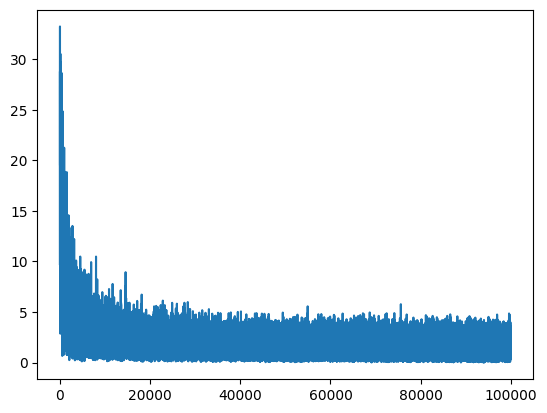

In [12]:
batch_size = 4
num_iter = 100000
train_loss = []

# We want to calculate gradients for all parameters when training
for p in parameters:
  p.requires_grad = True

for i in range(num_iter):
    batch_idxs = torch.randint(0, X_train.shape[0], (batch_size,))

    embeddings = C[X_train[batch_idxs]]
    h = torch.tanh(embeddings.view(-1, W1.shape[0]) @ W1 + b1) 
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, y_train[batch_idxs])

    # Backward
    for p in parameters: # Reset gradients before backward pass
        p.grad = None
    loss.backward()

    # Update gradients with sharper learning rate in the start
    lr = 0.01 if i < 1000 else 0.05
    for p in parameters:
        p.data += -lr * p.grad

    train_loss.append(loss.item())

plt.plot([i for i in range(num_iter)], train_loss)

In [13]:
train_loss[-10:]

[1.3442747592926025,
 2.162874460220337,
 1.150926947593689,
 0.40205705165863037,
 1.4311473369598389,
 1.3240506649017334,
 2.4455506801605225,
 1.1595568656921387,
 2.565973997116089,
 1.6574114561080933]

#### Did it overfit?

Training loss and validation loss should be similar. If train loss is way below valid, it is overfitted.

In [14]:
embeddings = C[X_train]
h = torch.tanh(embeddings.view(-1, W1.shape[0]) @ W1 + b1) 
logits = h @ W2 + b2 
loss = F.cross_entropy(logits, y_train)
loss

tensor(1.6387, grad_fn=<NllLossBackward0>)

In [15]:
embeddings = C[X_val]
h = torch.tanh(embeddings.view(-1, W1.shape[0]) @ W1 + b1) 
logits = h @ W2 + b2 
loss = F.cross_entropy(logits, y_val)
loss

tensor(3.2754, grad_fn=<NllLossBackward0>)

## Generate names

- Should be able to start each name with capital letter
- The loop keeps generating char by char until the END_TOKEN is sampled. 
    - Each char is sampled from the probability distribution that the network outputs, given the context tensor as input.
- High probability that many of the generated names exist in the dataset it is trained on.

In [16]:
num = 30
for _ in range(num):
    name = []
    context = [stoi[START_TOKEN]] * context_size 
    while True:
        embeddings = C[torch.tensor([context])] # (1, context_size, embedding_dim)
        h = torch.tanh(embeddings.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        idx = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [idx]
        if idx == stoi[END_TOKEN]: break
        name.append(itos[idx])
    name = ''.join(name)
    exist = "(In dataset)" if name in names else "(Generated)"
    print(f"Mr. {name} {exist}")

Mr. Koce (Generated)
Mr. Theo (In dataset)
Mr. Tobert (Generated)
Mr. Matliel (Generated)
Mr. Mohammaded (Generated)
Mr. Moison (Generated)
Mr. Noel (In dataset)
Mr. Matum (Generated)
Mr. Kane (In dataset)
Mr. Hasriel (Generated)
Mr. Harry (In dataset)
Mr. Kairo (In dataset)
Mr. Nicos (Generated)
Mr. Kall (Generated)
Mr. Adeustus (Generated)
Mr. Quint (Generated)
Mr. Frantii (Generated)
Mr. Matticus (Generated)
Mr. Ksrius (Generated)
Mr. Kudlan (Generated)
Mr. Mackson (Generated)
Mr. Garryne (Generated)
Mr. Karson (In dataset)
Mr. Chris (In dataset)
Mr. Maxiogo (Generated)
Mr. Feres (Generated)
Mr. Mohammanuel (Generated)
Mr. Ari (In dataset)
Mr. Karence (Generated)
Mr. Kaleso (Generated)
